# 1. Imports

In [1]:
import numpy as np
from math import pi

from matplotlib import pyplot as plt

import seaborn as sn
import pandas as pd

In [2]:
from tensorflow.keras.models import load_model

In [3]:
from tensorflow.keras.losses import MSE
from tensorflow.keras.losses import categorical_crossentropy as CCE
import tensorflow as tf

In [4]:
from art.attacks.evasion import *
from art.estimators.classification import TensorFlowV2Classifier

import os
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [5]:
# Load properties from another python file
from properties import *

In [6]:
from random import random, randint

# 2. Load models

In [7]:
path_model = "ACAS_XU_tf_keras/ACASXU_1_1.h5"

In [8]:
model_11 = load_model(path_model)

In [ ]:
model_35 = load_model("ACAS_XU_tf_keras/ACASXU_3_5.h5")

In [ ]:
model_11.summary()

In [9]:
model_11.compile()

In [ ]:
model_35.compile()

In [ ]:
pt = np.array([1.0, 1.0, 1.0, 1.0, 1.0]).reshape(1,5)
model_11.predict(pt)

In [ ]:
pt = np.array([1.0, 1.0, 1.0, 1.0, 1.0]).reshape(1,5)
model_35.predict(pt)

In [10]:
ACAS_model = model_11

# 3. FGSM

In [ ]:
def generate_adv_sample(model, x0, label, loss_function="MSE", eps=1e-5):
    # transforming into a tensorflow object
    x0_ = tf.cast(x0, tf.float32)
    
    # record our gradients
    with tf.GradientTape() as tape:
        # explicitly indicate that our input should be tacked for gradient updates
        tape.watch(x0_)

        # use our model to make predictions on the input and then compute the loss
        pred = model(x0_)
        if loss_function == "CCE":
            np_label = np.array([i==label for i in range(0,5)]).reshape((1,5))
            loss = CCE(np_label, pred)
        elif loss_function == "MSE":
            loss = MSE(label, pred)
        else:
            raise Exception("Unknown loss function '{0}'".format(loss_function))
        
        # calculate the gradients of loss with respect to the input, then compute the sign of the gradient
        gradient = tape.gradient(loss, x0_)
        signedGrad = tf.sign(gradient)

        # construct the image adversary
        adv_sample = (x0_ + (signedGrad * eps)).numpy()

        # return the adversarial sample to the calling function
        return(adv_sample)

# 4. Generate points

In [ ]:
def random_pts(n, prop_dom, main_dom):
    """ prop_dom is a list of domains given by intervals in a numpy 2x5 table. """
    ndom = len(prop_dom)
    ndim = main_dom.shape[1]
    
    x = np.zeros((n,ndim))
    for i in range(n): # generate the i-th point
        choosen_dom = prop_dom[randint(0,ndom-1)] # choose the input property domain for a given prop
        for k in range(ndim): # create a random coord for each dim
            boundaries = main_dom[:,k]
            if choosen_dom[0,k] != None:
                boundaries[0] = choosen_dom[0,k]
            if choosen_dom[1,k] != None:
                boundaries[1] = choosen_dom[1,k]
            x[i,k] = boundaries[0] + random()*(boundaries[1]-boundaries[0])

    return(x)

In [ ]:
def random_main_pts(n, main_dom):
    """ Generate random points in the main domain given by intervals stored in a numpy 2x5 table. """
    ndim = main_dom.shape[1]
    
    x = np.zeros((n,ndim))
    for k in range(ndim): # create a random coord for each dim
        col = main_dom[0,k]*np.ones((n,1)) + np.random.rand(n,1)*(main_dom[1,k] - main_dom[0,k])
        for i in range(n):
            x[i,k] = col[i]

    return(x)

In [ ]:
x_test = random_main_pts(1000, X_dom)

In [ ]:
def normalize(x, x_mean, x_range):
    (n,k) = x.shape
    nx = np.zeros((n,k))
    for i in range(n):
        for j in range(k):
            nx[i,j] = (x[i,j]-x_mean[j])/x_range[j]
    return(nx)

In [ ]:
def check_pts(model, input_pts, IP, OP):
    n = input_pts.shape[0]
    IO_check = np.zeros((n,2)) # 1st column : input checked - 2nd column : output checked
    
    norm_input = normalize(input_pts, X_mean, X_range) # normalize pts
    
    pred_pts = model.predict(norm_input) # make predictions with the model (neural net)
    
    for k in range(n):
        IO_check[k,0] = IP(input_pts[k,:]) # check input (just in case)
        IO_check[k,1] = OP(pred_pts[k,:]) # check output

    return(IO_check, pred_pts)

In [ ]:
rand_inputs = random_pts(1000000, IP2_dom, X_dom)

In [ ]:
Pcheck, pred_pts = check_pts(model_11, rand_inputs, IP1, OP1)

In [ ]:
def find_adverse(input_pts, prop_check):
    n = prop_check.shape[0]
    index = []
    for k in range(n):
        if prop_check[k,0] and not(prop_check[k,1]):
            index.append(k)
    return(input_pts[index,:])

In [ ]:
adv = find_adverse(rand_inputs, Pcheck)
print(adv.shape)

In [ ]:
Pcheck.shape

# 5. Attack the networks : FGSM & CW

In [34]:
ACAS_model = load_model("ACAS_XU_tf_keras/ACASXU_2_4.h5")

### Define the attacks

In [35]:
# Classifier object <~> neural network ACAS-Xu ...

ACAS_classifier = TensorFlowV2Classifier(model = ACAS_model,
                                         loss_object = MSE, # MSE or CCE ?...
                                         train_step = None,
                                         nb_classes = 5,
                                         input_shape = (1, 5, 1),
                                         clip_values = (-1.0, 1.0))

In [ ]:
# x_test = 0.8*np.array([ [1.0, 1.0, 1.0, 1.0, 1.0],
#                         [0.6, 0.5, 1.0, 0.3, 1.0] ])

Carlini-Wagner (CW) attack

In [36]:
attack_CW = CarliniLInfMethod(classifier=ACAS_classifier,
                              initial_const = 1.0, 
                              max_iter = 100, 
                              # targeted=True, 
                              verbose = True)

# x_adv_cw = attack_CW.generate(x_test) #, y=np.array([[0,1,0,0,0]]))
# print(x_adv_cw)

Fast Gradient Sign Method (FGSM) attack

In [37]:
intensity_fgsm = 0.8

attack_FGSM = FastGradientMethod(estimator = ACAS_classifier,
                                 eps = intensity_fgsm)

# x_adv_fgsm = attack_FGSM.generate(x_test)
# print(x_adv_fgsm)

### Create random (normalized) points

In [38]:
original_pts = np.random.rand(1000, 5) # random_main_pts(10, X_dom)

In [17]:
print(original_pts)

[[0.76830627 0.52625757 0.63057784 0.84970256 0.12826136]
 [0.29287982 0.37831122 0.67717346 0.02992429 0.70559888]
 [0.14302361 0.0917562  0.22385754 0.5931272  0.24412429]
 ...
 [0.34937638 0.9471524  0.90867038 0.54171453 0.91603414]
 [0.2582764  0.86312649 0.68463625 0.18181338 0.17777323]
 [0.40612166 0.303844   0.42994302 0.32165554 0.22895306]]


### Apply the attacks

In [18]:
# CW
adv_pts_cw = attack_CW.generate(original_pts)

In [52]:
# FGSM
adv_pts_fgsm = attack_FGSM.generate(original_pts)

In [20]:
print("CW adv points")
print(adv_pts_cw,"\n")

print("FGSM adv points")
print(adv_pts_fgsm)

CW adv points
[[0.76830626 0.5262576  0.63057786 0.84970254 0.12826136]
 [0.29287982 0.37831122 0.67717344 0.02992429 0.7055989 ]
 [0.14302361 0.0917562  0.22385754 0.5931272  0.2441243 ]
 ...
 [0.34937638 0.9471524  0.90867037 0.54171455 0.91603416]
 [0.2582764  0.8631265  0.68463624 0.18181337 0.17777322]
 [0.40612167 0.303844   0.42994303 0.32165554 0.22895305]] 

FGSM adv points
[[-0.03169373 -0.27374244 -0.16942215  0.04970256  0.92826134]
 [-0.5071202   1.         -0.12282654  0.8299243  -0.09440111]
 [ 0.9430236  -0.7082438  -0.5761425   1.          1.        ]
 ...
 [-0.45062363  0.1471524   0.10867038 -0.25828546  1.        ]
 [-0.5417236   0.0631265  -0.11536375 -0.61818665  0.97777325]
 [-0.39387834 -0.496156   -0.370057    1.          1.        ]]


In [21]:
# Make predictions with the adversarial points

original_pred = ACAS_model.predict(original_pts)
adv_pred_cw = ACAS_model.predict(adv_pts_cw)
adv_pred_fgsm = ACAS_model.predict(adv_pts_fgsm)

print("Original pred :")
print(original_pred,"\n")

print("CW pred :")
print(adv_pred_cw,"\n")

print("FGSM pred :")
print(adv_pred_fgsm)

Original pred :
[[0.19946052 0.20015194 0.20013621 0.20013647 0.20011479]
 [0.19952877 0.20013227 0.20011573 0.2001145  0.2001087 ]
 [0.19956154 0.20012225 0.2001063  0.20010488 0.200105  ]
 ...
 [0.1994313  0.20016111 0.2001445  0.20014471 0.20011841]
 [0.1994308  0.20016056 0.20014514 0.20014599 0.2001175 ]
 [0.19955795 0.20012386 0.20010696 0.20010509 0.20010611]] 

CW pred :
[[0.19946052 0.20015194 0.20013621 0.20013647 0.20011479]
 [0.19952877 0.20013227 0.20011573 0.2001145  0.2001087 ]
 [0.19956154 0.20012225 0.2001063  0.20010488 0.200105  ]
 ...
 [0.1994313  0.20016111 0.2001445  0.20014471 0.20011841]
 [0.1994308  0.20016056 0.20014514 0.20014599 0.2001175 ]
 [0.19955795 0.20012386 0.20010696 0.20010509 0.20010611]] 

FGSM pred :
[[0.19958445 0.20011601 0.20009917 0.20009692 0.20010345]
 [0.09427588 0.24716148 0.15785016 0.44311404 0.0575984 ]
 [0.19960797 0.2001086  0.20009254 0.20009035 0.2001005 ]
 ...
 [0.10609905 0.23975204 0.16476323 0.42235887 0.06702682]
 [0.0947131  

In [55]:
original_advice = np.argmin(original_pred, axis=1)
adv_pred_fgsm = ACAS_model.predict(adv_pts_fgsm)
fgsm_advice = np.argmin(adv_pred_fgsm, axis=1)

In [22]:
# Get advices from the predictions of the network (prediction = min score)

original_advice = np.argmin(original_pred, axis=1)
cw_advice = np.argmin(adv_pred_cw, axis=1)
fgsm_advice = np.argmin(adv_pred_fgsm, axis=1)

print(original_advice[:20])
print(cw_advice[:20])
print(fgsm_advice[:20])

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 4 0 4 0 0 0 1 0 0 0 0 4 0 4 0 0 0 3 0]


### Results visualization with confusion matrix

In [23]:
def confusion_matrix(pred0, pred1, n_classes=5):
    """ Create the n_classes*n_classes confusion matrix of pred1 compared to the original pred0. 
        - cmat[i,j] = nb of pts classified as i at the origin and as j after the attack """
    cmat = np.zeros((n_classes,n_classes)).astype(int)
    n_sample = pred0.shape[0]
    for k in range(n_sample):
        cmat[pred0[k],pred1[k]] += 1
    return(cmat)

In [64]:
def norm_rows(cmat):
    """ Normalize the lines of the confusion matrix cmat. """
    n = cmat.shape[0]
    ncmat = np.zeros((n,n))
    sum_rows = np.sum(cmat, axis=1)
    for k in range(n):
        s = sum_rows[k]
        if s != 0:
            ncmat[k,:] = cmat[k,:]/sum_rows[k]
    return(ncmat)

In [25]:
# confusion matrix
cmat_cw = confusion_matrix(original_advice, cw_advice)
print(cmat_cw)

# confusion matrix with normalized lines
ncmat_cw = norm_rows(cmat_cw)
print(ncmat_cw)

[[924   0   0   1   0]
 [  0   0   0   0   0]
 [  0   0  22   0   2]
 [  1   0   1  14   1]
 [  0   0   6   5  23]]
[[0.99891892 0.         0.         0.00108108 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.         0.         0.91666667 0.         0.08333333]
 [0.05882353 0.         0.05882353 0.82352941 0.05882353]
 [0.         0.         0.17647059 0.14705882 0.67647059]]


In [65]:
# confusion matrix
cmat_fgsm = confusion_matrix(original_advice, fgsm_advice)
print(cmat_fgsm)

# confusion matrix with normalized lines
ncmat_fgsm = norm_rows(cmat_fgsm)
print(ncmat_fgsm)

[[535  64   0 104   8]
 [ 71  48   0  25   0]
 [  0   0   0   0   0]
 [ 95  20   0  22   7]
 [  1   0   0   0   0]]
[[0.75246132 0.09001406 0.         0.14627286 0.01125176]
 [0.49305556 0.33333333 0.         0.17361111 0.        ]
 [0.         0.         0.         0.         0.        ]
 [0.65972222 0.13888889 0.         0.15277778 0.04861111]
 [1.         0.         0.         0.         0.        ]]


In [59]:
print(np.sum(cmat_fgsm, axis=1))

[711 144   0 144   1]


In [27]:
# confusion matrix plot legend
index0 = ["COC","WR","WL","SR","SL"]
index1 = ["adv-COC","adv-WR","adv-WL","adv-SR","adv-SL"]

### Plot confusion matrix for CW attack

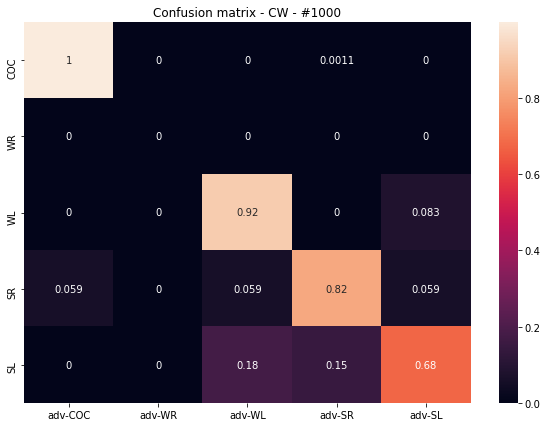

In [28]:
df_cmat = pd.DataFrame(ncmat_cw, index = index0, columns = index1)

plt.figure(figsize = (10,7))
sn.heatmap(df_cmat, annot=True)
plt.title("Confusion matrix - CW - #{0}".format(1000))
plt.show()

### Plot confusion matrix for FGSM attack

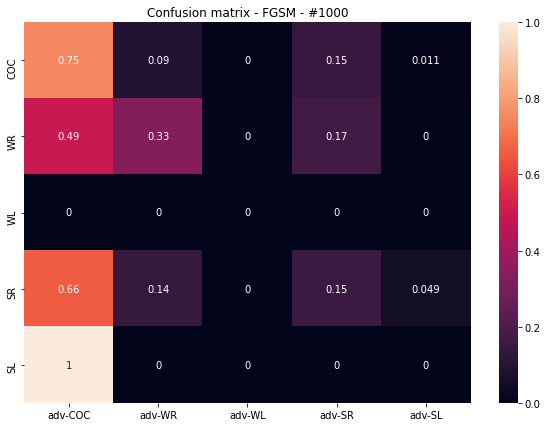

In [66]:
df_cmat = pd.DataFrame(ncmat_fgsm, index = index0, columns = index1)

plt.figure(figsize = (10,7))
sn.heatmap(df_cmat, annot=True)
plt.title("Confusion matrix - FGSM - #{0}".format(1000))
plt.show()

### Sauvegarde des pts dans un fichier

In [30]:
np.save("clear_pts.npy",original_pts)

In [31]:
test_data = np.load("clear_pts.npy")

### Test des categories manquantes

In [103]:
Npts = 1000

In [119]:
def get_count(npts, nets_id=None):
    
    if nets_id == None: # all 45 networks
        nets_id = []
        for k in range(11,60):
            if k%10 != 0:
                nets_id.append( (str(k//10),str(k%10)) )
    else:
        for k in range(0,len(nets_id)):
            (na,nb) = nets_id[k]
            nets_id[k] = (str(na),str(nb))
                
    original_pts = np.random.rand(npts, 5) # random_main_pts(10, X_dom)
    
    nnets = len(nets_id)
    total_count = np.zeros((nnets,5))
    
    for k in range(0,nnets):
        (a,b) = nets_id[k]
        ACAS_model = load_model("ACAS_XU_tf_keras/ACASXU_{0}_{1}.h5".format(a,b))
        
        original_pred = ACAS_model.predict(original_pts)
        advice = np.concatenate( (np.argmin(original_pred, axis=1),np.array([0,1,2,3,4])) )
        
        total_count[k,:] = (np.bincount(advice) - np.ones(5)).astype(int)
        print('ACAS-XU {0}-{1} : {2}'.format(a,b,total_count[k,:]))
        
    return(total_count)

In [107]:
u = np.array([1,2,3]) ; print(u)
v = np.array([1,2,3]) ; print(v)
w = np.concatenate((u,v)) ; print(w)

[1 2 3]
[1 2 3]
[1 2 3 1 2 3]


In [122]:
warnings.filterwarnings('ignore')

In [124]:
total_count = get_count(Npts) #, nets_id = [(1,1),(2,2),(3,5)])

ACAS-XU 1-1 : [902.   0.  35.  36.  27.]
ACAS-XU 1-2 : [891.  13.  51.   6.  39.]
ACAS-XU 1-3 : [914.   2.  42.  24.  18.]
ACAS-XU 1-4 : [929.   5.   2.  35.  29.]
ACAS-XU 1-5 : [888.   1.   1. 100.  10.]
ACAS-XU 1-6 : [965.  10.  15.   5.   5.]
ACAS-XU 1-7 : [968.   0.   0.   0.  32.]
ACAS-XU 1-8 : [966.   5.   0.  29.   0.]
ACAS-XU 1-9 : [1000.    0.    0.    0.    0.]
ACAS-XU 2-1 : [669. 254.   0.  76.   1.]
ACAS-XU 2-2 : [811.  46.   0. 134.   9.]
ACAS-XU 2-3 : [755. 140.   0. 104.   1.]
ACAS-XU 2-4 : [677. 148.   0. 174.   1.]
ACAS-XU 2-5 : [910.  72.   0.  18.   0.]
ACAS-XU 2-6 : [880. 119.   0.   1.   0.]
ACAS-XU 2-7 : [939.  50.   2.   9.   0.]
ACAS-XU 2-8 : [887. 113.   0.   0.   0.]
ACAS-XU 2-9 : [895. 102.   0.   3.   0.]
ACAS-XU 3-1 : [848.   0. 127.   1.  24.]
ACAS-XU 3-2 : [905.   0.  49.   0.  46.]
ACAS-XU 3-3 : [777.   0. 125.   1.  97.]
ACAS-XU 3-4 : [895.   0.  94.   2.   9.]
ACAS-XU 3-5 : [904.   0.  84.   0.  12.]
ACAS-XU 3-6 : [865.   0. 135.   0.   0.]
ACAS-XU 3-7

In [125]:
print(total_count)

[[ 902.    0.   35.   36.   27.]
 [ 891.   13.   51.    6.   39.]
 [ 914.    2.   42.   24.   18.]
 [ 929.    5.    2.   35.   29.]
 [ 888.    1.    1.  100.   10.]
 [ 965.   10.   15.    5.    5.]
 [ 968.    0.    0.    0.   32.]
 [ 966.    5.    0.   29.    0.]
 [1000.    0.    0.    0.    0.]
 [ 669.  254.    0.   76.    1.]
 [ 811.   46.    0.  134.    9.]
 [ 755.  140.    0.  104.    1.]
 [ 677.  148.    0.  174.    1.]
 [ 910.   72.    0.   18.    0.]
 [ 880.  119.    0.    1.    0.]
 [ 939.   50.    2.    9.    0.]
 [ 887.  113.    0.    0.    0.]
 [ 895.  102.    0.    3.    0.]
 [ 848.    0.  127.    1.   24.]
 [ 905.    0.   49.    0.   46.]
 [ 777.    0.  125.    1.   97.]
 [ 895.    0.   94.    2.    9.]
 [ 904.    0.   84.    0.   12.]
 [ 865.    0.  135.    0.    0.]
 [ 741.    0.  259.    0.    0.]
 [ 676.    0.  321.    0.    3.]
 [ 812.    0.  187.    1.    0.]
 [ 930.   44.    0.   26.    0.]
 [ 922.   37.    0.   35.    6.]
 [ 895.   57.    0.   48.    0.]
 [ 913.   

In [129]:
df_count = pd.DataFrame(total_count, columns = index0)

In [133]:
df_count.head()

,COC,WR,WL,SR,SL
0,902.0,0.0,35.0,36.0,27.0
1,891.0,13.0,51.0,6.0,39.0
2,914.0,2.0,42.0,24.0,18.0
3,929.0,5.0,2.0,35.0,29.0
4,888.0,1.0,1.0,100.0,10.0


In [136]:
sn.histplot(df_count['COC'])
plt.show()

AttributeError: module 'seaborn' has no attribute 'histplot'

In [ ]:
!pip uninstall seaborn